## Récupération des données de l'API

In [5]:
import json
import matplotlib.pyplot as plt
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
import requests
import scipy as sp
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA


parametres = {
    'start_date':'2019-01-01',
    'end_date':'2019-09-07',
    'columns':['spend','revenue','profit','margin','nb_impressions','ecpm']}

r = requests.post('https://data-analyst-test.madboxgames.io/api/public/profit/get',params=parametres)


## Transformation des données en dataframe

In [6]:
data = r.text

j = json.loads(data)

y = j['data']

df = pd.DataFrame(j['data']['data'])


df['date'] = pd.to_datetime(df['date']) 
df.set_index('date', inplace=True)


df.head()

,ecpm,margin,nb_impressions,profit,revenue,spend
date,,,,,,
2019-01-01,49.59,0.34,59751.76,993.28,2963.14,1969.86
2019-01-02,49.98,0.32,62299.62,1002.36,3113.48,2111.12
2019-01-03,48.27,0.34,65199.64,1074.17,3146.88,2072.72
2019-01-04,49.73,0.33,63996.98,1061.52,3182.79,2121.26
2019-01-05,48.49,0.32,64038.54,992.10,3105.02,2112.92


In [7]:
df.describe()

,ecpm,margin,nb_impressions,profit,revenue,spend
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,50.058040,0.332000,79909.440360,1329.731320,3998.940000,2669.208600
std,1.276493,0.016743,8510.587954,161.063956,427.070377,287.826362
min,47.410000,0.300000,59751.760000,967.530000,2963.140000,1969.860000
25%,48.980000,0.320000,74008.952500,1214.000000,3664.420000,2462.900000
50%,49.985000,0.330000,79813.155000,1329.920000,3974.565000,2661.170000
75%,50.985000,0.340000,86349.677500,1439.602500,4306.485000,2888.230000
max,52.960000,0.370000,99058.080000,1791.140000,4990.630000,3317.850000


## Visualisation des différentes données

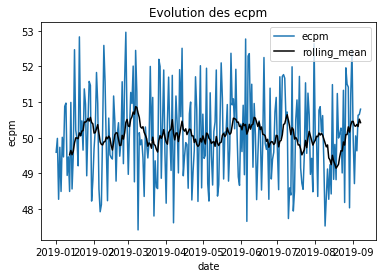

In [105]:
rolling_mean = df.rolling(window = 12).mean()

plt.plot(df.ecpm, label = 'ecpm')
plt.plot(rolling_mean.ecpm, 'black', label = 'rolling_mean')

plt.title("Evolution des ecpm")
plt.legend()
plt.xlabel("date")
plt.ylabel("ecpm")

plt.show()



plt.show()

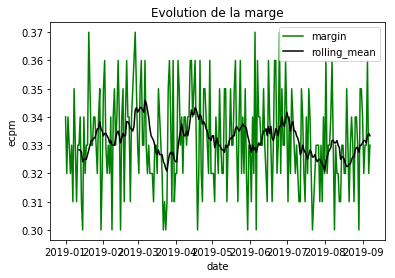

In [11]:
plt.plot(df.margin, 'g', label = 'margin')
plt.plot(rolling_mean.margin, 'black', label = 'rolling_mean')

plt.title("Evolution de la marge")
plt.legend()
plt.xlabel("date")
plt.ylabel("ecpm")

plt.show()

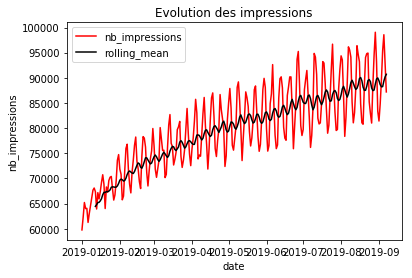

In [12]:
plt.plot(df.nb_impressions, 'r', label = 'nb_impressions')
plt.plot(rolling_mean.nb_impressions, 'black', label = 'rolling_mean')

plt.title("Evolution des impressions")
plt.legend()
plt.xlabel("date")
plt.ylabel("nb_impressions")

plt.show()

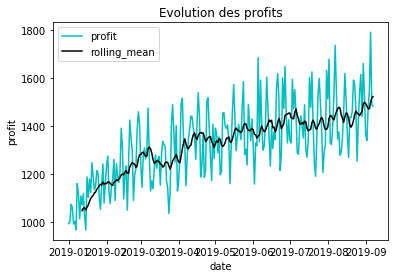

In [13]:
plt.plot(df.index, df.profit, 'c', label = 'profit')
plt.plot(rolling_mean.profit, 'black', label = 'rolling_mean')

plt.title("Evolution des profits")
plt.legend()
plt.xlabel("date")
plt.ylabel("profit")

plt.show()

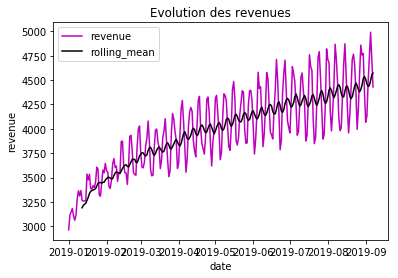

In [14]:
plt.plot(df.index, df.revenue, 'm', label = 'revenue')
plt.plot(rolling_mean.revenue, 'black', label = 'rolling_mean')

plt.title("Evolution des revenues")
plt.legend()
plt.xlabel("date")
plt.ylabel("revenue")

plt.show()

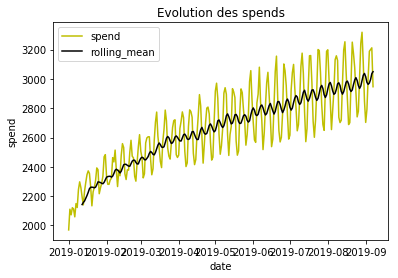

In [15]:
plt.plot(df.index, df.spend, 'y', label = 'spend')
plt.plot(rolling_mean.spend, 'black', label = 'rolling_mean')

plt.title("Evolution des spends")
plt.legend()
plt.xlabel("date")
plt.ylabel("spend")

plt.show()

Ici, on remarque que les données suivent 2 tendances :
- ecrm et margin semblent être des valeurs semi-constantes
- le reste des champs ont l'air de courbes logarithmiques

## Algorithme de prédiction des profits : Arima

/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


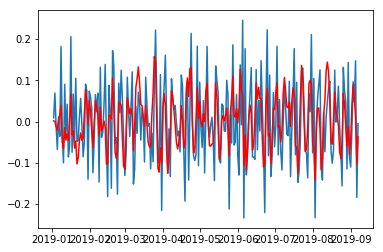

In [112]:
df_log = np.log(df.profit)
df_log_shift = df_log - df_log.shift()

decomposition = seasonal_decompose(df_log) 
model = ARIMA(df_log, order=(2,1,2))
results = model.fit()
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')

plt.show()


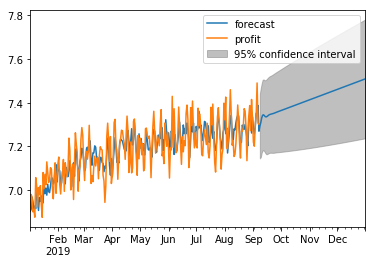

In [95]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log.iloc[0], index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)

results.plot_predict(end='2019-12-31')

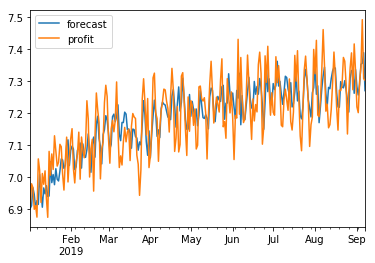

In [110]:
results.plot_predict(dynamic=False)
plt.show()